Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

Download the data from the source website if necessary.

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a string.

In [3]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


Build the dictionary and replace rare words with UNK token.

In [4]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156]


Function to generate a training batch for the skip-gram model.

In [5]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['as', 'anarchism', 'originated', 'a', 'term', 'as', 'a', 'of']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['originated', 'term', 'anarchism', 'a', 'term', 'as', 'originated', 'of']


Train a skip-gram model.

In [6]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [7]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings_skip_gram = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.970412
Nearest to had: stanford, stipulates, slopes, sooty, pisces, boudin, iain, responsive,
Nearest to their: batch, germinal, bohdan, alcal, truth, conducive, propyl, ainsworth,
Nearest to can: endogamy, chalk, fatimids, spruce, mpla, drawing, cryptography, darth,
Nearest to th: distillation, northerly, spalding, crts, wi, khmer, fort, irregularities,
Nearest to many: visualize, hobbyists, fulfilled, bishops, clergy, avon, sweyn, covert,
Nearest to all: mp, benson, remorse, aeneas, clausius, frontal, adobe, masurian,
Nearest to often: sram, ren, hx, lander, interiors, laws, dudayev, gigantopithecus,
Nearest to one: papyrus, apprehended, denaturation, gemstones, macrolides, exponentially, volatile, patrols,
Nearest to up: nicknames, joab, fidesz, dilapidated, freedoms, kellerman, columnists, tribunes,
Nearest to zero: sefer, slams, variational, cleaves, magnitude, gibbons, circumnavigation, nominees,
Nearest to that: ido, fastest, specialties, sa

In [10]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings_skip_gram[1:num_points+1, :])

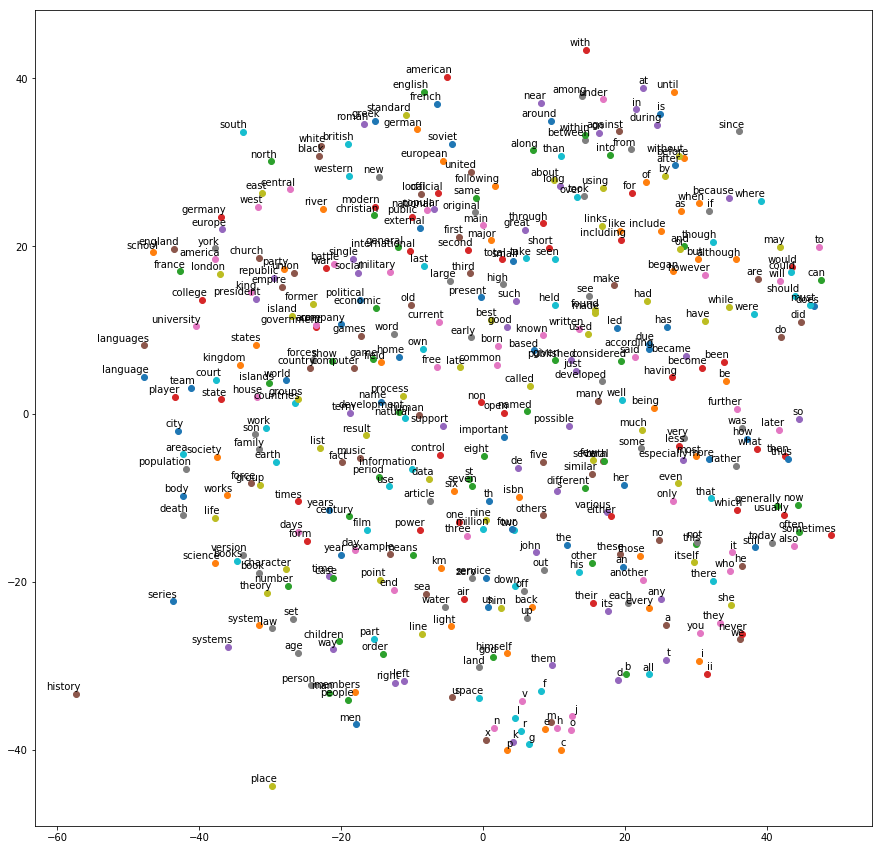

In [11]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

So in the skip-gram model, we created a correspondance between a word (vector) and another word (vector) chosen in the same context. The "context" here was basically one word before or after. The role of the neural net was then to predict what is the most likely word coming before or after a given word. Using the softmax function, the network was actually outputing a probability distribution on words and the most likely words could be interpreted as the "context".

In the CBOW formulation, we will predict a word from its context. Hence the input is not a single word vector, but the sum of several word (vectors). Let's say we want to predict word $w_i$ from a sentence, the context will be $w_{i-2}$, $w_{i-1}$, $w_{i+1}$ and $w_{i+2}$. The input will be the sum of the word vectors of the context, while the labels will be the vector corresponding to the word $w_i$.

To achieve this, we first need to rewrite the batch generation function.

In [12]:
data_index = 0

def generate_batch_cbow(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size-2,num_skips), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size-2,1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  for i in range(batch_size-2): # // num_skips
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index+_])
    target = skip_window  # target label at the center of the buffer
    batch[i,:] = [buffer[j] for j in range(span) if j != target]
    labels[i,0] = buffer[target]
    data_index = (data_index + 1) % len(data)
  return batch, labels


print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1)]:
    data_index = 0
    batch, labels = generate_batch_cbow(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [(reverse_dictionary[bi[0]],reverse_dictionary[bi[1]]) for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(6)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: [('anarchism', 'as'), ('originated', 'a'), ('as', 'term'), ('a', 'of'), ('term', 'abuse'), ('of', 'first')]
    labels: ['originated', 'as', 'a', 'term', 'of', 'abuse']


Next we can train a skip-gram model. Note that the architecture of the network is identical, only the shape of the inputs is different.

In [13]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
context_window = 1 # How many words to consider left and right.
context_size = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size-2,context_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size-2, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  embed_context = tf.reduce_mean(embed, 1)
  
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed_context,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [14]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch_cbow(
      batch_size, context_size, context_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings_cbow = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.725165
Nearest to five: brunel, vaikundar, heliports, inferred, sun, apostol, predefined, tou,
Nearest to on: porta, marche, fu, quay, bauxite, nostra, meine, keeshond,
Nearest to system: minimally, embalming, kary, poorer, approaches, sade, gymnast, object,
Nearest to united: alighieri, linebacker, javan, superpowers, bodies, ideally, codeine, habitats,
Nearest to but: intimately, ghidorah, stuck, ceased, decentralisation, communicator, replacement, hiring,
Nearest to will: petrels, monatomic, iupac, brennan, widowed, enlist, fruitarians, moorland,
Nearest to years: hasdrubal, overloaded, turpentine, mortis, extremity, antidote, comply, realizing,
Nearest to known: elway, risky, stripper, enjoyed, flair, hymenoptera, northumbria, bbses,
Nearest to was: sinan, winchester, impressively, favre, athos, jer, islander, blend,
Nearest to three: pens, mutagens, training, serial, beacon, drinkers, measured, wakefield,
Nearest to are: mug, stenella, breakbe

Ok, we've trained our word embedding. Now we need to understand how good it is, and how better/worse it is w.r.t. skip-gram.
It seems there are basically two main approaches to evaluate the quality of a word embedding and compare it to another. 
1. We can use a supervised task that uses the embedding and compute a specific metric to the task at hand.
2. We can use an external "query inventory" which basically lists similarities between pairs of word, and compare them wth the similarities based on the embedding. The similarities from the query inventory are based on human review.

We will use the second approach and for that use the WordSimilarity-353 dataset [3]. It contains 200 pairs of words whose similarity has been rated by 16 people. 

Refs.

[1] T. Schnabel, I. Labutov, D. Mimno, T. Joachims, *Evaluation methods for unsupervised word embeddings*, Proceedings of the 2015 Conference on Empirical Methods in Natural Language Processing. 2015.

[2] M. Baroni, G. Dinu, G. Kruszewski. 2014. *Don’t count, predict! a systematic comparison of context-counting vs. context-predicting semantic vectors*.

[3] https://www.aclweb.org/aclwiki/index.php?title=WordSimilarity-353_Test_Collection_(State_of_the_art)

Let's first download and read the dataset

In [41]:
url = 'http://www.cs.technion.ac.il/~gabr/resources/data/wordsim353/'

def maybe_download_2(filename):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  return filename

def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  wordspairs = np.ndarray(shape=(200,2),dtype=object)  
  similarity = np.ndarray(shape=200,dtype=np.float)  
  with zipfile.ZipFile(filename) as f:
    file = f.open('set2.csv','r')    
    for i,line in enumerate(file.readlines()[1:]):
        wordspairs[i,:] = line.split(',')[:2]
        similarity[i] = np.float(line.split(',')[2])
  return wordspairs, similarity

filename = maybe_download_2('wordsim353.zip')
wordspairs,similarity = read_data(filename)

Next we need to rescale the similarity on a scale from 0 to 1, compute the cosine similarity of each pairs with our embeddings and compare the computed similarity with the 'true' similarity.

In [42]:
similarity = (similarity-5)/5
for i,wordspair in enumerate(wordspairs):
    print("similarity score for pair ",wordspair,' : ', similarity[i])

similarity score for pair  ['energy' 'secretary']  :  -0.638
similarity score for pair  ['secretary' 'senate']  :  0.012
similarity score for pair  ['energy' 'laboratory']  :  0.018
similarity score for pair  ['computer' 'laboratory']  :  0.356
similarity score for pair  ['weapon' 'secret']  :  0.212
similarity score for pair  ['FBI' 'fingerprint']  :  0.388
similarity score for pair  ['FBI' 'investigation']  :  0.662
similarity score for pair  ['investigation' 'effort']  :  -0.082
similarity score for pair  ['Mars' 'water']  :  -0.412
similarity score for pair  ['Mars' 'scientist']  :  0.126
similarity score for pair  ['news' 'report']  :  0.632
similarity score for pair  ['canyon' 'landscape']  :  0.506
similarity score for pair  ['image' 'surface']  :  -0.088
similarity score for pair  ['discovery' 'space']  :  0.268
similarity score for pair  ['water' 'seepage']  :  0.312
similarity score for pair  ['sign' 'recess']  :  -0.524
similarity score for pair  ['Wednesday' 'news']  :  -0.

In [52]:
word1_index = np.empty(shape=(200),dtype = np.int)
word2_index = np.empty(shape=(200),dtype = np.int)

for i,wordpair in enumerate(wordspairs):
    try :
        word1_index[i] = dictionary[wordpair[0].lower()]
    except KeyError:
        print("Word %s not in dictionnary." %wordpair[0])
        word1_index[i] = 0
    try :
        word2_index[i] = dictionary[wordpair[1].lower()]
    except KeyError:
        print("Word %s not in dictionnary." %wordpair[1])
        word2_index[i] = 0
        continue

with graph.as_default(), tf.device('/cpu:0'):
  word1 = tf.constant(word1_index,dtype=tf.int32)
  word2 = tf.constant(word2_index,dtype=tf.int32)
  word1_embeddings = tf.nn.embedding_lookup(final_embeddings_skip_gram, word1)
  word2_embeddings = tf.nn.embedding_lookup(final_embeddings_skip_gram, word2)
  similarity_skip = tf.reduce_sum(tf.multiply(word1_embeddings, word2_embeddings),axis=1)

Word seepage not in dictionnary.


In [53]:
with tf.Session(graph=graph) as session:
    sim_skip = similarity_skip.eval()  

In [43]:
word1_index = np.empty(shape=(200),dtype = np.int)
word2_index = np.empty(shape=(200),dtype = np.int)

for i,wordpair in enumerate(wordspairs):
    try :
        word1_index[i] = dictionary[wordpair[0].lower()]
    except KeyError:
        print("Word %s not in dictionnary." %wordpair[0])
        word1_index[i] = 0
    try :
        word2_index[i] = dictionary[wordpair[1].lower()]
    except KeyError:
        print("Word %s not in dictionnary." %wordpair[1])
        word2_index[i] = 0
        continue

with graph.as_default(), tf.device('/cpu:0'):
  word1 = tf.constant(word1_index,dtype=tf.int32)
  word2 = tf.constant(word2_index,dtype=tf.int32)
  word1_embeddings = tf.nn.embedding_lookup(final_embeddings_cbow, word1)
  word2_embeddings = tf.nn.embedding_lookup(final_embeddings_cbow, word2)
  similarity_cbow = tf.reduce_sum(tf.multiply(word1_embeddings, word2_embeddings),axis=1)

Word seepage not in dictionnary.


In [54]:
with tf.Session(graph=graph) as session:
    sim_cbow = similarity_cbow.eval()  

In [56]:
score_cbow = np.mean((similarity-sim_cbow)**2)
score_skip = np.mean((similarity-sim_skip)**2)
print('Score for skip-gram model is : %f .\nScore for CBOW model is : %f .' %(score_skip,score_cbow))

Score for skip-gram model is : 0.153535 .
Score for CBOW model is : 0.148035 .


On that validation set, we can see that CBOW is doing slightly better.

The tensorflow tutorial suggests another method to validate embeddings. It also uses an external query inventory dataset, but this time, it is to measure the ability to recover semantic analogies. In that case, we provide, three words (e.g. France, Paris, Berlin) and check how far the fourth semantically associated word is from F-P+B. 

I will try that if I have some time later. For now I will go on with LSTM's